
# Backtesting SMA Crossover Strategy

**Author:** William Bradbury  

**Email:** wbradbury1@outlook.com  

**LinkedIn:** https://www.linkedin.com/in/williamjbradbury/  

**GitHub:** https://github.com/wbradbury1  

**Affiliation:** University of Warwick — BSc Mathematics 

This notebook implements and evaluates a **Simple Moving Average (SMA) crossover** trading strategy
in Python. It is cleaned for GitHub: no outputs, execution counts stripped, and code formatted.

## Features:
- Data via yfinance (adjusted close)
- Configurable SMA windows
- Vectorized signals with no look-ahead
- Metrics: CAGR, Annualized Vol, Sharpe, Max Drawdown
- Plots: Price with SMAs + Buy/Sell, Equity curves, Drawdowns

## How to Run
1. Install the required packages:
   ```bash
   pip install -r requirements.txt
   ```
2. Open the notebook in Jupyter (`jupyter lab`).
3. Run all cells in order. 



In [1]:
# If yfinance not installed and error returned, uncomment following line:
# !pip install yfinance

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [3]:
# Parameters
TICKER = "SPY"         # The asset we test, identified by its ticker symbol (e.g. SPY for S&P 500 ETF)
START  = "2000-01-01"  # Start date for data (YYYY-MM-DD)
END    = None          # End date; None means "today"

SHORT_WINDOW = 50   # Number of trading days in the "short" SMA (Simple Moving Average)
LONG_WINDOW  = 200  # Number of trading days in the "long" SMA (Simple Moving Average)

INITIAL_CAPITAL = 100000  # Starting portfolio value (in dollars, pounds, whatever)

In [4]:
# Data Importing
START_fixed = (pd.to_datetime(START) - pd.DateOffset(years=1)).strftime("%Y-%m-%d")  # Starts year before date we are interested in to remove NaN values
data = yf.download(TICKER, start=START_fixed, end=END, auto_adjust=True)             # Prefer Adjusted because it accounts for dividends and splits hence above auto_adjust=True

df = data[["Close"]].copy()          # Interested only in close price
df.index = pd.to_datetime(df.index)  # Index is now date
df = df.sort_index().dropna()        # Ensured rows are in date order and removed any missing values

print(f"Downloaded {TICKER}: {len(df)} rows, {df.index.min().date()} → {df.index.max().date()}")
df.head()

[*********************100%***********************]  1 of 1 completed

Downloaded SPY: 6702 rows, 1999-01-04 → 2025-08-25


Price,Close
Ticker,SPY
Date,
1999-01-04,77.117310
1999-01-05,77.998795
1999-01-06,79.879196
1999-01-07,79.487434
1999-01-08,80.075073


## Strategy Logic
We compute the short-term and long-term Simple Moving Averages (SMAs). A signal is generated when the short SMA crosses above or below the long SMA.

In [5]:
# Indicators
df["SMA_short"] = df["Close"].rolling(window=SHORT_WINDOW, min_periods=SHORT_WINDOW).mean() # Short SMA column
df["SMA_long"]  = df["Close"].rolling(window=LONG_WINDOW,  min_periods=LONG_WINDOW ).mean() # Long SMA column
df = df.loc[START:].dropna().copy()                                                         # Slice DataFrame to original start date to remove NaN values for both SMA columns (Simple Moving Average).
df.head()

Price,Close,SMA_short,SMA_long
Ticker,SPY,,
Date,,,
2000-01-03,92.142509,88.689524,85.061950
2000-01-04,88.539169,88.815915,85.096427
2000-01-05,88.697601,88.953770,85.143477
2000-01-06,87.272087,89.083654,85.181142
2000-01-07,92.340515,89.285677,85.236000


## Signal and Position Construction
We generate binary signals (long/flat) based on SMA crossovers, shift by one day to avoid look-ahead bias, and calculate strategy returns and equity curves.

In [6]:
# Signals and Equity
df["signal"] = (df["SMA_short"] > df["SMA_long"]).astype(float)           # 1 if SMA_short > SMA_long else 0 and type set to float to assist in later calculations
df["position"] = df["signal"].shift(1).fillna(0.0)                        # use yesterday's signal (avoid look-ahead)
df["ret"] = df["Close"].pct_change().fillna(0.0)                          # daily returns from price
df["strategy_ret"] = df["position"] * df["ret"]                           # strategy returns (only earn if position held)
df["equity"]    = (1.0 + df["strategy_ret"]).cumprod() * INITIAL_CAPITAL  # SMA strategy equity
df["bh_equity"] = (1.0 + df["ret"]).cumprod() * INITIAL_CAPITAL           # Buy & Hold equity
df.head()

Price,Close,SMA_short,SMA_long,signal,position,ret,strategy_ret,equity,bh_equity
Ticker,SPY,,,,,,,,
Date,,,,,,,,,
2000-01-03,92.142509,88.689524,85.061950,1.0,0.0,0.000000,0.000000,100000.000000,100000.000000
2000-01-04,88.539169,88.815915,85.096427,1.0,1.0,-0.039106,-0.039106,96089.383532,96089.383532
2000-01-05,88.697601,88.953770,85.143477,1.0,1.0,0.001789,0.001789,96261.325894,96261.325894
2000-01-06,87.272087,89.083654,85.181142,1.0,1.0,-0.016072,-0.016072,94714.250359,94714.250359
2000-01-07,92.340515,89.285677,85.236000,1.0,1.0,0.058076,0.058076,100214.890692,100214.890692


## Performance Metrics
We calculate standard performance statistics:
- CAGR (annual growth rate)
- Annualized volatility
- Sharpe ratio (without risk-free)
- Maximum drawdown

In [7]:
# Performance Metrics
# We compute 4 metrics:

# 1. CAGR (Compound Annual Growth Rate)
# 2. Annualized Volatility
# 3. Sharpe Ratio (no risk-free)
# 4. Maximum Drawdown

# Defining functions with type and return hints for data formatting

def cagr(equity: pd.Series) -> float:
  # Geometric mean of returns, scaled to a yearly basis
    start_val = float(equity.iloc[0])
    end_val   = float(equity.iloc[-1])
    years = (equity.index[-1] - equity.index[0]).days / 365.25
    return (end_val / start_val) ** (1.0 / years) - 1.0


def annualized_vol(daily_returns: pd.Series) -> float:
  # Standard deviation of daily returns scaled by sqrt(252) -- 252 trading days per year
    return daily_returns.std() * np.sqrt(252)

def sharpe_no_rf(daily_returns: pd.Series) -> float:
  # Measures return per unit of risk
    return (daily_returns.mean() / daily_returns.std()) * np.sqrt(252)

def max_drawdown(equity: pd.Series) -> float:
  # Worst drop from a peak to a trough
    running_max = equity.cummax()
    dd = (equity / running_max) - 1
    return dd.min()

In [8]:
# Calculate metrics for SMA and Buy & Hold (Simple Moving Average)
metrics = {
    "SMA": {
        "CAGR":   cagr(df["equity"]),
        "Vol":    annualized_vol(df["strategy_ret"]),
        "Sharpe": sharpe_no_rf(df["strategy_ret"]),
        "MaxDD":  max_drawdown(df["equity"])
    },
    "Buy&Hold": {
        "CAGR":   cagr(df["bh_equity"]),
        "Vol":    annualized_vol(df["ret"]),
        "Sharpe": sharpe_no_rf(df["ret"]),
        "MaxDD":  max_drawdown(df["bh_equity"])
    }
}

# Print results to 2 d.p.
print("Performance Summary")
for strategy, m in metrics.items(): # Loop running through above dictionary
    print(f"\n{strategy}")
    print(f"  CAGR:   {m['CAGR']:.2%}")
    print(f"  Vol:    {m['Vol']:.2%}")
    print(f"  Sharpe: {m['Sharpe']:.2f}")
    print(f"  MaxDD:  {m['MaxDD']:.2%}")

Performance Summary

SMA
  CAGR:   7.75%
  Vol:    13.43%
  Sharpe: 0.62
  MaxDD:  -33.72%

Buy&Hold
  CAGR:   7.87%
  Vol:    19.48%
  Sharpe: 0.49
  MaxDD:  -55.19%


## Results: Price and SMAs
We plot the asset price with both SMAs and mark the Buy/Sell points.

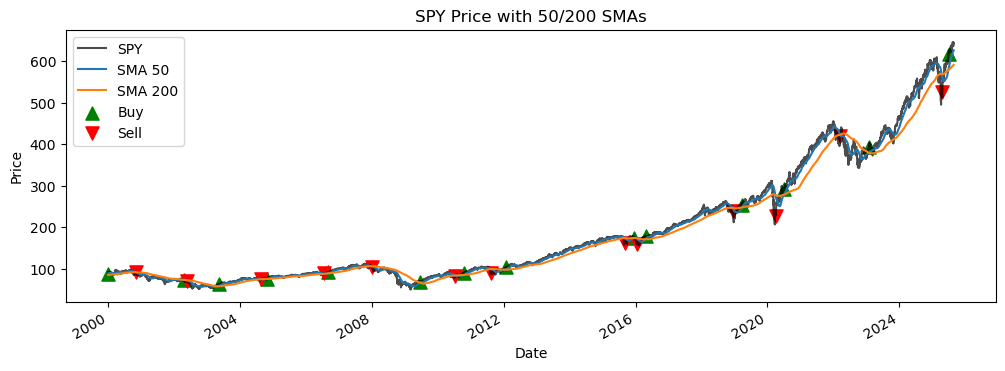

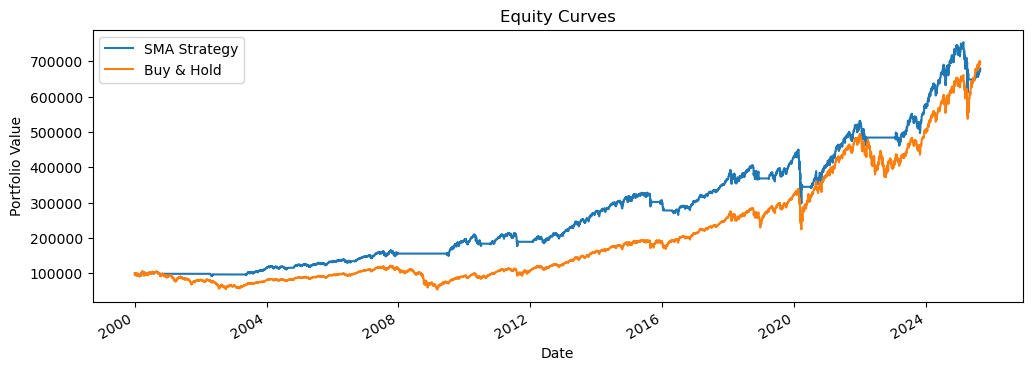

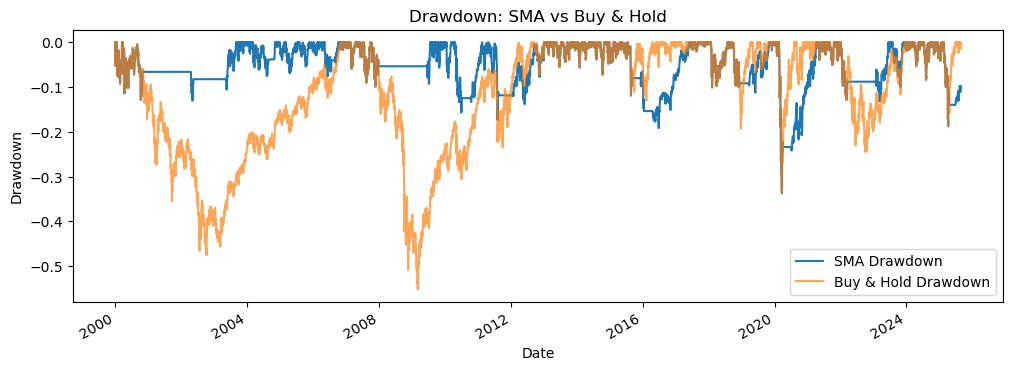

In [9]:
# Plots

# 1) Price + SMAs (Simple Moving Average)
# Find where position changes (turnover points)
turns = df['position'].diff().fillna(0)
buy_idx = df.index[turns > 0]  # Buy = points where we switch into a long (diff = +1)
sell_idx = df.index[turns < 0]  # Sell = points where we exit to flat (diff = -1)

fig, ax = plt.subplots(figsize=(12,4))
df["Close"].plot(ax=ax, label="Close", c="k", alpha=0.7)
df["SMA_short"].plot(ax=ax, label=f"SMA {SHORT_WINDOW}")
df["SMA_long"].plot(ax=ax, label=f"SMA {LONG_WINDOW}")
ax.scatter(buy_idx,  df.loc[buy_idx, 'Close'],  marker='^', c='green', s=90, label='Buy')
ax.scatter(sell_idx, df.loc[sell_idx, 'Close'], marker='v', c='red',   s=90, label='Sell')
ax.set_title(f"{TICKER} Price with {SHORT_WINDOW}/{LONG_WINDOW} SMAs")
ax.set_xlabel("Date")
ax.set_ylabel("Price")
ax.legend()
plt.show()

# 2) Equity curves
fig, ax = plt.subplots(figsize=(12,4))
df["equity"].plot(ax=ax, label="SMA Strategy")
df["bh_equity"].plot(ax=ax, label="Buy & Hold")
ax.set_title("Equity Curves")
ax.set_xlabel("Date")
ax.set_ylabel("Portfolio Value")
ax.legend()
plt.show()

# 3) Drawdowns
# Compute drawdowns for both curves
dd_sma = df['equity'] / df['equity'].cummax() - 1
dd_bh  = df['bh_equity'] / df['bh_equity'].cummax() - 1

fig, ax = plt.subplots(figsize=(12,4))
dd_sma.plot(ax=ax, label='SMA Drawdown')
dd_bh.plot(ax=ax,  label='Buy & Hold Drawdown', alpha=0.7)
ax.set_title('Drawdown: SMA vs Buy & Hold')
ax.set_xlabel('Date')
ax.set_ylabel('Drawdown')
ax.legend()
plt.show()

## Conclusion

The SMA crossover strategy was evaluated on SPY from 2000–present, covering multiple market regimes (dot-com crash, 2008 financial crisis, COVID-19 shock, and long bull markets).  

- **CAGR:** Buy & Hold slightly outperformed on raw returns (7.87% vs 7.75%).  
- **Volatility:** SMA had noticeably lower volatility (13.4% vs 19.5%).  
- **Sharpe ratio:** SMA achieved a higher Sharpe (0.62 vs 0.49), indicating superior risk-adjusted performance.  
- **Max Drawdown:** SMA’s worst drawdown was much smaller (–33.7% vs –55.2%), showing stronger downside protection.  

**Summary:**  
Over the past two decades, the SMA crossover strategy slightly trailed behind Buy & Hold in absolute returns, but it **delivered better risk-adjusted performance and significantly reduced drawdowns**.  

I also tested different moving average windows (e.g. 10/50, 20/100, 50/200) and across multiple assets (AAPL, BTC-USD). The pattern was consistent: shorter SMAs made the strategy more reactive but prone to whipsaws in more volatile markets, while longer SMAs were steadier but slower to respond. In most cases, the strategy offered valuable **protection in bear markets**, yet tended to **lag behind Buy & Hold in strong bull markets**.
